Orange Is the New Stat
----------------------

This notebook contains code that demonstrates the effect of the inspection paradox on observations of a prison population, which I wrote about in this article on my blog, Probably Overthinking It:

http://allendowney.blogspot.com/2015/08/orange-is-new-stat.html

Copyright 2015 Allen Downey

MIT License: http://opensource.org/licenses/MIT

In [41]:
from __future__ import print_function, division

import numpy as np
import thinkplot
import thinkstats2

from collections import Counter

%matplotlib inline
formats = ['png', 'pdf']

To model the distribution of sentences, I use random values from a gamma distribution, rounded to the nearest integer.  All sentences are in units of months.

In [42]:
sentences = np.random.gamma(shape=2, scale=60, size=1000).astype(int)
cdf1 = thinkstats2.Cdf(sentences, label='actual')
thinkplot.PrePlot(2)
thinkplot.Cdf(cdf1)
thinkplot.Config(xlabel='sentence (months)', ylabel='CDF')
thinkplot.Save('orange1', formats=formats)

Writing orange1.png
Writing orange1.pdf


I chose parameters that very roughly match the histogram of sentences in this report: http://www.ussc.gov/sites/default/files/pdf/research-and-publications/quick-facts/Quick-Facts_BOP.pdf

In my distribution about 28% of sentences are less than 5 years, and 40% are more than 10.

In [43]:
(sentences < 5*12).mean(), (sentences > 10*12).mean()

(0.25800000000000001, 0.41599999999999998)

If we imagine a series of sentences served consecutively, we can compute the release date for each prisoner:

In [44]:
releases = sentences.cumsum()

For example, here are the sentences of the first 10 prisoners:

In [45]:
sentences[:10]

array([193,  69, 148, 107, 123, 189,  61, 219, 104,  83])

And the release dates of the first 10 prisoners:

In [46]:
releases[:10]

array([ 193,  262,  410,  517,  640,  829,  890, 1109, 1213, 1296])

If we arrive during month 500, we can figure out which prisoner we would observe using `searchsorted`, which uses bisection search.  The result is an array index, which we can think of as a prisoner ID.

In [47]:
releases.searchsorted(500)

3

The following function chooses a random prisoner by choosing a random arrival time, `i`, looking up the prisoner who would be observed at `i`, and then looking up that prisoner's sentence.

In [48]:
def random_sample(sentences, releases):
    i = np.random.random_integers(1, releases[-1])
    prisoner = releases.searchsorted(i)
    sentence = sentences[prisoner]
    return i, prisoner, sentence

If we call `random_sample` a few times, we get a sample of sentences as seen by random arrivals.

In [49]:
for _ in range(10):
    print(random_sample(sentences, releases))

(78300, 633, 54)
(37764, 310, 57)
(106242, 871, 110)
(84510, 678, 229)
(38545, 318, 95)
(85459, 684, 201)
(54732, 453, 100)
(77412, 623, 120)
(82512, 667, 212)
(120811, 995, 50)


We can be a little more efficient by generating 1000 random arrival times and finding the corresponding sentences.  Then we compute the CDF of the resulting sample.

In [50]:
arrivals = np.random.random_integers(1, releases[-1], 10000)
prisoners = releases.searchsorted(arrivals)
sample = sentences[prisoners]
cdf2 = thinkstats2.Cdf(sample, label='biased')

Here's what the biased sample looks like, compared to the actual distribution.  Due to the inspection paradox, we oversample long sentences.

In [60]:
thinkplot.PrePlot(2)
thinkplot.Cdf(cdf1)
thinkplot.Cdf(cdf2)
thinkplot.Config(xlabel='sentence (months)', ylabel='CDF', loc='lower right')
thinkplot.Save('orange2', formats=formats)

Writing orange2.png
Writing orange2.pdf


As expected, the sample mean is substantially higher than the actual mean:

In [52]:
sentences.mean(), sample.mean()

(121.14100000000001, 182.9058)

Instead of using a random sample, we could have computed the biased distribution directly by applying an operation on the PMF.  The following function takes the actual distribution of sentences, weights each sentence length, `x`, by `x`, and renormalizes.

This operation is discussed in Section 3.4 of Think Stats: http://greenteapress.com/thinkstats2/html/thinkstats2004.html#toc29

In [53]:
def bias_pmf(pmf, t=0, label=None):
    label = label if label is not None else pmf.label
    new_pmf = pmf.Copy(label=label)

    for x, p in pmf.Items():
        new_pmf[x] *= (x + t)
        
    new_pmf.Normalize()
    return new_pmf

pmf = thinkstats2.Pmf(sentences)
biased = bias_pmf(pmf, t=0, label='BiasPmf').MakeCdf()

This figure compares the biased distribution computed by random sampling with the distribution computed by `BiasPmf`.  They should be similar.

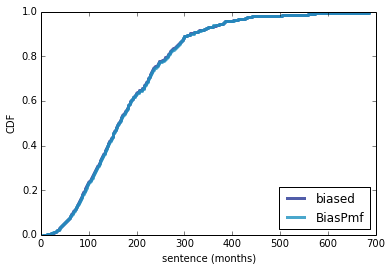

In [54]:
thinkplot.PrePlot(2)
thinkplot.Cdf(cdf2)
thinkplot.Cdf(biased)
thinkplot.Config(xlabel='sentence (months)', ylabel='CDF', loc='lower right')

Now we get to the scenario I describe in the article: observation made by a prisoner serving a sentence with duration `t`.

The following function computes this distribution, given an array of (actual) sentences and the sentence of the observer.

It starts by choosing a random arrival time between 1 and the maximum sentence.  So the initial observation is subject to the inspection paradox.

Each time through the loop it computes `first_prisoner`, which is the prisoner observed on arrival, and `last_prisoner`, the prisoner observed on departure.  The prisoners between these endpoints (including both) are considered one observed sample, and added to the Counter object, which accumulates a histogram of observed sentences.

Each time through the loop, the arrival time is advanced by 100, which is approximately the average sentence.  This has the effect of thinning the observations.

Finally, the function returns the CDF of the observed sentences.


In [55]:
def simulate_sentence(sentences, t):
    counter = Counter()
    
    releases = sentences.cumsum()
    last_release = releases[-1]
    arrival = np.random.random_integers(1, max(sentences))
    
    for i in range(arrival, last_release-t, 100):
        first_prisoner = releases.searchsorted(i)
        last_prisoner = releases.searchsorted(i+t)
    
        observed_sentences = sentences[first_prisoner:last_prisoner+1]
        counter.update(observed_sentences)
    
    print(sum(counter.values()))
    return thinkstats2.Cdf(counter, label='observed %d' % t)

The following function takes an observed distribution of sentences and plots it along with the actual distribution and the biased distribution that would be seen by a single arrival.

In [56]:
def plot_cdfs(cdf3):
    thinkplot.PrePlot(2)
    thinkplot.Cdf(cdf1)
    thinkplot.Cdf(cdf2)
    thinkplot.Cdf(cdf3, color='orange')
    thinkplot.Config(xlabel='sentence (months)', ylabel='CDF', loc='lower right')

If the sentence of the observer is only 11 months, the observed distribution is almost as biased as what would be seen by an instantaneous observer.

In [67]:
cdf13 = simulate_sentence(sentences, 13)
#cdf13 = bias_pmf(pmf, 13).MakeCdf()
plot_cdfs(cdf13)
thinkplot.Save('orange3', formats=formats)

1341
Writing orange3.png
Writing orange3.pdf


With a longer sentence, we get a less biased view.  But even after 120 months, which is the average sentence, the observed sample is still quite biased.

In [68]:
cdf120 = simulate_sentence(sentences, 120)
#cdf120 = bias_pmf(pmf, 120).MakeCdf()
plot_cdfs(cdf120)
thinkplot.Save('orange4', formats=formats)

2397
Writing orange4.png
Writing orange4.pdf


After 600 months (50 years!) the observed distribution almost reaches the actual distribution.

In [69]:
cdf600 = simulate_sentence(sentences, 600)
#cdf600 = bias_pmf(pmf, 600).MakeCdf()
plot_cdfs(cdf600)
thinkplot.Save('orange5', formats=formats)

7166
Writing orange5.png
Writing orange5.pdf


We conclude that during Kerman's 11 month sentence, she would have seen a biased sample of the distribution of sentences.

Nevertheless, her observation that many prisoners are serving long sentences that do not fit their crimes is still valid, in my opinion.

In [71]:
thinkplot.PrePlot(cols=3)
plot_cdfs(cdf13)
thinkplot.SubPlot(2)
plot_cdfs(cdf120)
thinkplot.SubPlot(3)
plot_cdfs(cdf600)
thinkplot.Save('orange6', formats=formats)

Writing orange6.png
Writing orange6.pdf
